# EXPLORATORY DATA ANALYSIS (I.)

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 60)

In [3]:
KEYS = [
    'entity_id',
    'financial_report_id',
    'financial_statement_id',
    'entity_ico',
    'entity_name']

DIMENSIONS = [
    'year',
    # 'month',
    # 'financial_report_order_number',
    'period_length',
    # 'consolidated',
    # 'approved_date',
    'type',
    'financial_report_template_id',
    # 'establishment_date',
    # 'cancellation_date',
    # 'sknace_code',
    # 'entity_state',
    'legal_form_code',
    'org_size_code',
    'ownership_category_code',
    'entity_consolidated',
    # 'sknace_division_name',
    'sknace_division',
    'sknace_division_normalized',
    # 'sknace_subcategory',
    'sal_class',
    'is_mahalanobis_outlier',
    'is_isolation_forest_outlier']


RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]

DISTRESS_SIGNALS = [
    'DPHZ_vat_registration_cancelled',
    'DPHZ_vat_registration_cancelled_1y_off',
    'DPHZ_vat_registration_cancelled_2y_off',
    'DPHZ_vat_registration_cancelled_3y_off',
    'RU_event',
    'RU_event_1y_off',
    'RU_event_2y_off',
    'RU_event_3y_off',
    'cancellation_year',
    'RUZ_cancelled',
    'RUZ_cancelled_1y_off',
    'RUZ_cancelled_2y_off',
    'RUZ_cancelled_3y_off']

## Winsorizacia

In [4]:

training_raw = pd.read_csv('../../DATA/FINAL/training_sample.csv')
testing_raw = pd.read_csv('../../DATA/FINAL/testing_sample.csv')
data_raw = pd.read_csv('../../DATA/FINAL/super_sample.csv')


def winsorize(x, lower_bound, upper_bound):
    if x != x: return x
    if x < lower_bound: return lower_bound
    if x > upper_bound: return upper_bound
    return x

    
thresholds_skew = dict()
thresholds_sym = dict()

training_capped = training_raw.copy()
testing_capped = testing_raw.copy()
data_capped = data_raw.copy()

for col in RATIOS:
    if data_capped[col].min() >= 0:
        threshold_min = 0
        threshold_max = training_raw[col].quantile(0.95)
    else:
        threshold_min = training_raw[col].quantile(0.025)
        threshold_max = training_raw[col].quantile(0.975)

    training_capped[col] = training_raw[col].apply(lambda x: winsorize(x, threshold_min, threshold_max))
    testing_capped[col] = testing_raw[col].apply(lambda x: winsorize(x, threshold_min, threshold_max))
    data_capped[col] = data_raw[col].apply(lambda x: winsorize(x, threshold_min, threshold_max))

summary_non_capped = testing_raw[RATIOS].describe().T.reset_index().rename(columns={'index': 'ratio'}).reset_index()
summary_capped = testing_capped[RATIOS].describe().T.reset_index().rename(columns={'index': 'ratio'}).reset_index()

summary_non_capped['skew'] = list(testing_raw[RATIOS].skew())
summary_capped['skew'] = list(testing_capped[RATIOS].skew())

summary_non_capped['type'] = 'raw'
summary_capped['type'] = 'winsorized'

pd.concat([summary_non_capped, summary_capped], axis=0).sort_values(['index', 'type'])

training_capped.to_csv('../../DATA/FINAL/winsorized/training_sample.csv', index = False)
testing_capped.to_csv('../../DATA/FINAL/winsorized/testing_sample.csv', index = False)
data_capped.to_csv('../../DATA/FINAL/winsorized/super_sample.csv', index = False)

In [5]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

## Missing values imputation

In [6]:
mean_values = dict()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        subset_training = training_capped.query('sal_class == @sal_class and sknace_division == @sknace')
        segment_mean_values = dict()
        for col in RATIOS:
            mean_value = subset_training[col].mean()
            # if np.isnan(mean_value): print(sal_class, sknace, col)
            segment_mean_values[col] = mean_value
        
        mean_values[(sal_class, sknace)] = segment_mean_values
    


In [7]:
data_filled = pd.DataFrame()
training_filled = pd.DataFrame()
testing_filled = pd.DataFrame()

for sal_class in SAL_CLASSES:
    for sknace in SKNACE_GROUPS:
        subset_data = data_capped.query('sal_class == @sal_class and sknace_division_normalized == @sknace')
        subset_training = training_capped.query('sal_class == @sal_class and sknace_division_normalized == @sknace')
        subset_testing = testing_capped.query('sal_class == @sal_class and sknace_division_normalized == @sknace')
        segment_mean_values = mean_values[(sal_class, sknace)]

        for col in RATIOS:
            mean_value = segment_mean_values[col]
            subset_data[col] = subset_data[col].fillna(mean_value).fillna(0)
            subset_training[col] = subset_training[col].fillna(mean_value).fillna(0)
            subset_testing[col] = subset_testing[col].fillna(mean_value).fillna(0)

        data_filled = pd.concat([data_filled, subset_data], axis = 0)
        training_filled = pd.concat([training_filled, subset_training], axis = 0)
        testing_filled = pd.concat([testing_filled, subset_testing], axis = 0)

C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_5248\1245056479.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data[col] = subset_data[col].fillna(mean_value).fillna(0)
C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_5248\1245056479.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_training[col] = subset_training[col].fillna(mean_value).fillna(0)
C:\Users\matus.rohal\AppData\Local\Temp\ipykernel_5248\1245056479.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [8]:
training_filled.to_csv('../../DATA/FINAL/filled/training_sample.csv', index = False)
testing_filled.to_csv('../../DATA/FINAL/filled/testing_sample.csv', index = False)
data_filled.to_csv('../../DATA/FINAL/filled/super_sample.csv', index = False)

## One hot encoding

In [9]:
def one_hot_encode(df, categorical_columns):
    for col in categorical_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' does not exist in the DataFrame.")

    df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=False)
    
    return df_encoded

training_filled['sknace'] = training_filled['sknace_division_normalized'].copy()
testing_filled['sknace'] = testing_filled['sknace_division_normalized'].copy()
data_filled['sknace'] = data_filled['sknace_division_normalized'].copy()

training_filled = one_hot_encode(training_filled, ['sknace'])
testing_filled = one_hot_encode(testing_filled, ['sknace'])
data_filled = one_hot_encode(data_filled, ['sknace'])

training_filled.to_csv('../../DATA/FINAL/final/training_sample.csv', index = False)
testing_filled.to_csv('../../DATA/FINAL/final/testing_sample.csv', index = False)
data_filled.to_csv('../../DATA/FINAL/final/super_sample.csv', index = False)

In [10]:
def get_sample_sizes(data, row_label, column_label):
    samples_df = data.groupby([row_label, column_label])['financial_statement_id'].nunique().to_frame('count').reset_index()
    wide_df = pd.pivot_table(samples_df, index = row_label, columns=column_label, fill_value=0).reset_index()
    return wide_df

In [11]:
def get_counts_by(data, dim, label = None):

    data2 = data.copy()
    data2[dim] = 'Spolu'
    data['priority'] = 1
    data2['priority'] = 2
    data = pd.concat([data, data2], axis=0)

    total = data.groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('total')
    combined = data.query('combined_issue_criteria_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('combined')
    indirect = data.query('RUZ_indirect_criteria_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('indirect')
    cancelled = data.query('RUZ_cancelled_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('cancelled')
    insolvency = data.query('RU_event_3y_off == 1').groupby([dim, 'priority'])['financial_statement_id'].nunique().to_frame('insolvency')

    summary = (pd.concat(
        [
            total,
            combined,
            indirect,
            cancelled,
            insolvency
        ], axis = 1
    ).reset_index().sort_values(by=['priority', 'total'], ascending=[True, False]))

    summary['combined_p'] = (summary['combined'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')
    summary['indirect_p'] = (summary['indirect'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')
    summary['cancelled_p'] = (summary['cancelled'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')
    summary['insolvency_p'] = (summary['insolvency'] / summary['total']).apply(lambda x: f'{round(x * 100, 1)}%')

    if label is None: label = dim

    col_rename = {
        dim : label,
        'total' : 'Celkový počet',
        'combined_p' : 'Kombinované kritérium',
        'indirect_p' : 'Nepriame kritérium',
        'cancelled_p' : 'Zaniknutá spoločnosť',
        'insolvency_p' : 'Insolvenčné konanie'
    }

    display(summary[[dim, 'total', 'combined_p', 'indirect_p', 'cancelled_p', 'insolvency_p']].rename(columns=col_rename))
    
    print(summary[[dim, 'total', 'combined_p', 'indirect_p', 'cancelled_p', 'insolvency_p']].rename(columns=col_rename).to_latex(index=False))
    

get_counts_by(data_raw, 'sal_class', label = 'SK NACE')

SK NACE  Celkový počet Kombinované kritérium Nepriame kritérium  \
0     2. Malý           7331                 10.0%               7.7%   
1  3. Stredný           1654                  8.5%               6.1%   
2       Spolu           8985                  9.7%               7.4%   

  Zaniknutá spoločnosť Insolvenčné konanie  
0                 1.1%                2.5%  
1                 1.1%                2.7%  
2                 1.1%                2.6%

\begin{tabular}{lrllll}
\toprule
   SK NACE &  Celkový počet & Kombinované kritérium & Nepriame kritérium & Zaniknutá spoločnosť & Insolvenčné konanie \\
\midrule
   2. Malý &           7331 &                 10.0\% &               7.7\% &                 1.1\% &                2.5\% \\
3. Stredný &           1654 &                  8.5\% &               6.1\% &                 1.1\% &                2.7\% \\
     Spolu &           8985 &                  9.7\% &               7.4\% &                 1.1\% &                2.6\% \\
\bottomrule
\end{tabular}



## Outliers

In [12]:
print(1)
display(get_sample_sizes(data_filled, 'is_mahalanobis_outlier', 'is_isolation_forest_outlier'))

display(get_sample_sizes(data_filled, 'is_mahalanobis_outlier', 'combined_issue_criteria_3y_off'))
display(get_sample_sizes(data_filled, 'is_mahalanobis_outlier', 'RUZ_indirect_criteria_3y_off'))
display(get_sample_sizes(data_filled, 'is_mahalanobis_outlier', 'RUZ_cancelled_3y_off'))
display(get_sample_sizes(data_filled, 'is_mahalanobis_outlier', 'RU_event_3y_off'))

display(get_sample_sizes(data_filled, 'is_isolation_forest_outlier', 'combined_issue_criteria_3y_off'))
display(get_sample_sizes(data_filled, 'is_isolation_forest_outlier', 'RUZ_indirect_criteria_3y_off'))
display(get_sample_sizes(data_filled, 'is_isolation_forest_outlier', 'RUZ_cancelled_3y_off'))
display(get_sample_sizes(data_filled, 'is_isolation_forest_outlier', 'RU_event_3y_off'))

1


is_mahalanobis_outlier count     
is_isolation_forest_outlier                        False True
0                                            False  8755  129
1                                             True    49   52

is_mahalanobis_outlier count     
combined_issue_criteria_3y_off                          0.0  1.0
0                                               False  8045  839
1                                                True    68   33

is_mahalanobis_outlier count     
RUZ_indirect_criteria_3y_off                          0.0  1.0
0                                             False  8243  641
1                                              True    79   22

is_mahalanobis_outlier count    
RUZ_cancelled_3y_off                            0   1
0                                     False  8797  87
1                                      True    87  14

is_mahalanobis_outlier count     
RU_event_3y_off                          0.0  1.0
0                                False  8660  224
1                                 True    95    6

is_isolation_forest_outlier count     
combined_issue_criteria_3y_off                               0.0  1.0
0                                                    False  7970  834
1                                                     True   143   38

is_isolation_forest_outlier count     
RUZ_indirect_criteria_3y_off                               0.0  1.0
0                                                  False  8164  640
1                                                   True   158   23

is_isolation_forest_outlier count    
RUZ_cancelled_3y_off                                 0   1
0                                          False  8721  83
1                                           True   163  18

is_isolation_forest_outlier count     
RU_event_3y_off                               0.0  1.0
0                                     False  8581  223
1                                      True   174    7

## 1. Struktura udajov z pohladu velkostnej kategorie, oblasti zamerania etc.

In [13]:
display(data_capped.info())
display(data_capped[RATIOS].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8985 entries, 0 to 8984
Columns: 101 entries, entity_id to is_isolation_forest_outlier
dtypes: bool(3), float64(79), int64(9), object(10)
memory usage: 6.7+ MB


None

L1           L2           L3       NCL_CF      CASH_TA  \
count  8983.000000  8983.000000  8983.000000  8984.000000  8985.000000   
mean      0.525146     1.789133     2.326443     0.900011     0.129443   
std       0.826255     1.733222     2.097700     2.358469     0.154881   
min       0.000000     0.000361     0.000361    -1.006790     0.000000   
25%       0.037059     0.723741     1.057723     0.004564     0.013006   
50%       0.168512     1.188386     1.534738     0.068235     0.061664   
75%       0.577458     2.108252     2.687773     0.574854     0.189765   
max       3.212989     7.135926     8.763377    12.081125     0.533638   

          INV_COGS       CC_SAL      TL_COST      CL_COST       SAL_TA  \
count  6389.000000  8957.000000  8983.000000  8983.000000  8985.000000   
mean      7.814076     0.210952     0.520146     0.269441     2.345871   
std      22.412770     0.189032     0.606220     0.238925     1.674253   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.041743     0.086091     0.178867     0.113884     1.134381   
50%       0.211649     0.155895     0.305748     0.191979     1.949470   
75%       1.339976     0.262252     0.557111     0.326352     3.154883   
max      94.924400     0.772572     2.589372     0.985065     6.599492   

             EQ_TA        EQ_TL        CL_CC      LTC_NCA           TZ  \
count  8985.000000  8985.000000  8966.000000  8834.000000  8984.000000   
mean      0.351461     0.357468     2.020298     9.373802     0.469651   
std       0.268637     0.271126     2.397137    25.432218     6.882545   
min      -0.164890    -0.165510     0.000000     0.069719   -18.749789   
25%       0.136868     0.140829     0.692731     1.051080    -1.790588   
50%       0.313088     0.319329     1.130021     1.784400    -0.289261   
75%       0.545386     0.554296     2.098504     4.494160     2.151469   
max       0.910062     0.914643     9.916796   138.017947    24.924097   

             CF_TL        CL_TA       NCL_TA      EBT_REV          ROS  \
count  8984.000000  8985.000000  8985.000000  8985.000000  8957.000000   
mean      0.396584     0.424008     0.069673     0.056001     0.044978   
std       0.640200     0.261479     0.122441     0.095433     0.084988   
min      -0.122761     0.000000     0.000000    -0.102021    -0.108240   
25%       0.067853     0.207104     0.001140     0.006219     0.004197   
50%       0.175919     0.390877     0.010744     0.027113     0.021117   
75%       0.418369     0.621099     0.068351     0.075409     0.060187   
max       3.229242     0.923162     0.448514     0.416971     0.380309   

           EAT_REV          ROA          ROE        CF_TA       CF_SAL  \
count  8985.000000  8985.000000  8985.000000  8985.000000  8957.000000   
mean      0.043351     0.077766     0.193104     0.147112     0.096454   
std       0.078702     0.120515     0.413282     0.152043     0.123977   
min      -0.098736    -0.134910    -1.217556    -0.081707    -0.051982   
25%       0.004143     0.008155     0.027315     0.048180     0.021985   
50%       0.020854     0.042736     0.148808     0.107789     0.056914   
75%       0.059216     0.114525     0.382251     0.200416     0.124109   
max       0.339143     0.491577     1.017821     0.660174     0.581879   

         LABOR_EAT    LABOR_REV  
count  8982.000000  8985.000000  
mean      8.478387     0.118361  
std      22.780796     0.123895  
min     -18.098649     0.000000  
25%       0.164760     0.027169  
50%       1.755733     0.080050  
75%       6.498147     0.164719  
max     115.808817     0.521865

## 2. Analýza distribúcie prediktorov

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson

def plot_histograms(df, columns, apply_yeojohnson_transform=False):
    fig, axes = plt.subplots(nrows=int(len(columns) / 3) + 1, ncols=3, figsize=(20, 30))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        ax = axes[i]

        data = df.query(f'{column} == {column} and {column} != 0')[column]
        data_skewness = round(data.skew(), 1)

        if apply_yeojohnson_transform:
            data, _ = yeojohnson(data)
            transformation = 'Yeo-Johnson Transformed'
        else:
            transformation = 'Original'

        data_skewness_new = round(pd.Series(data).skew(), 1) 
        
        Q1 = np.quantile(data, 0.25)
        Q2 = np.quantile(data, 0.5)
        Q3 = np.quantile(data, 0.75)
        
        IQR = Q3 - Q1

        bin_width = 2 * IQR / (len(data) ** (1/3))
        num_bins = min(100, int(np.ceil((np.max(data) - np.min(data)) / bin_width)))

        sns.histplot(data, bins=num_bins, kde=True, color='skyblue', edgecolor='black', ax=ax)
        ax.set_title(f'{column}, {transformation}, original skewness: {data_skewness}, transformed skewness: {data_skewness_new}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

        mean = np.mean(data)
        std = np.std(data)
        for color, z_score_threshold in [('red', 3), ('blue', 2)]:
            lower_bound = mean - z_score_threshold * std
            upper_bound = mean + z_score_threshold * std
            ax.axvline(lower_bound, color=color, linewidth=1, label=f'Lower Bound, Threshold {z_score_threshold}')
            ax.axvline(upper_bound, color=color, linestyle='--', linewidth=1, label=f'Upper Bound, Threshold {z_score_threshold}')

        ax.axvline(Q2, color='green', linestyle='-', linewidth=2, label='Median')

        if i == 0:
            ax.legend()

    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

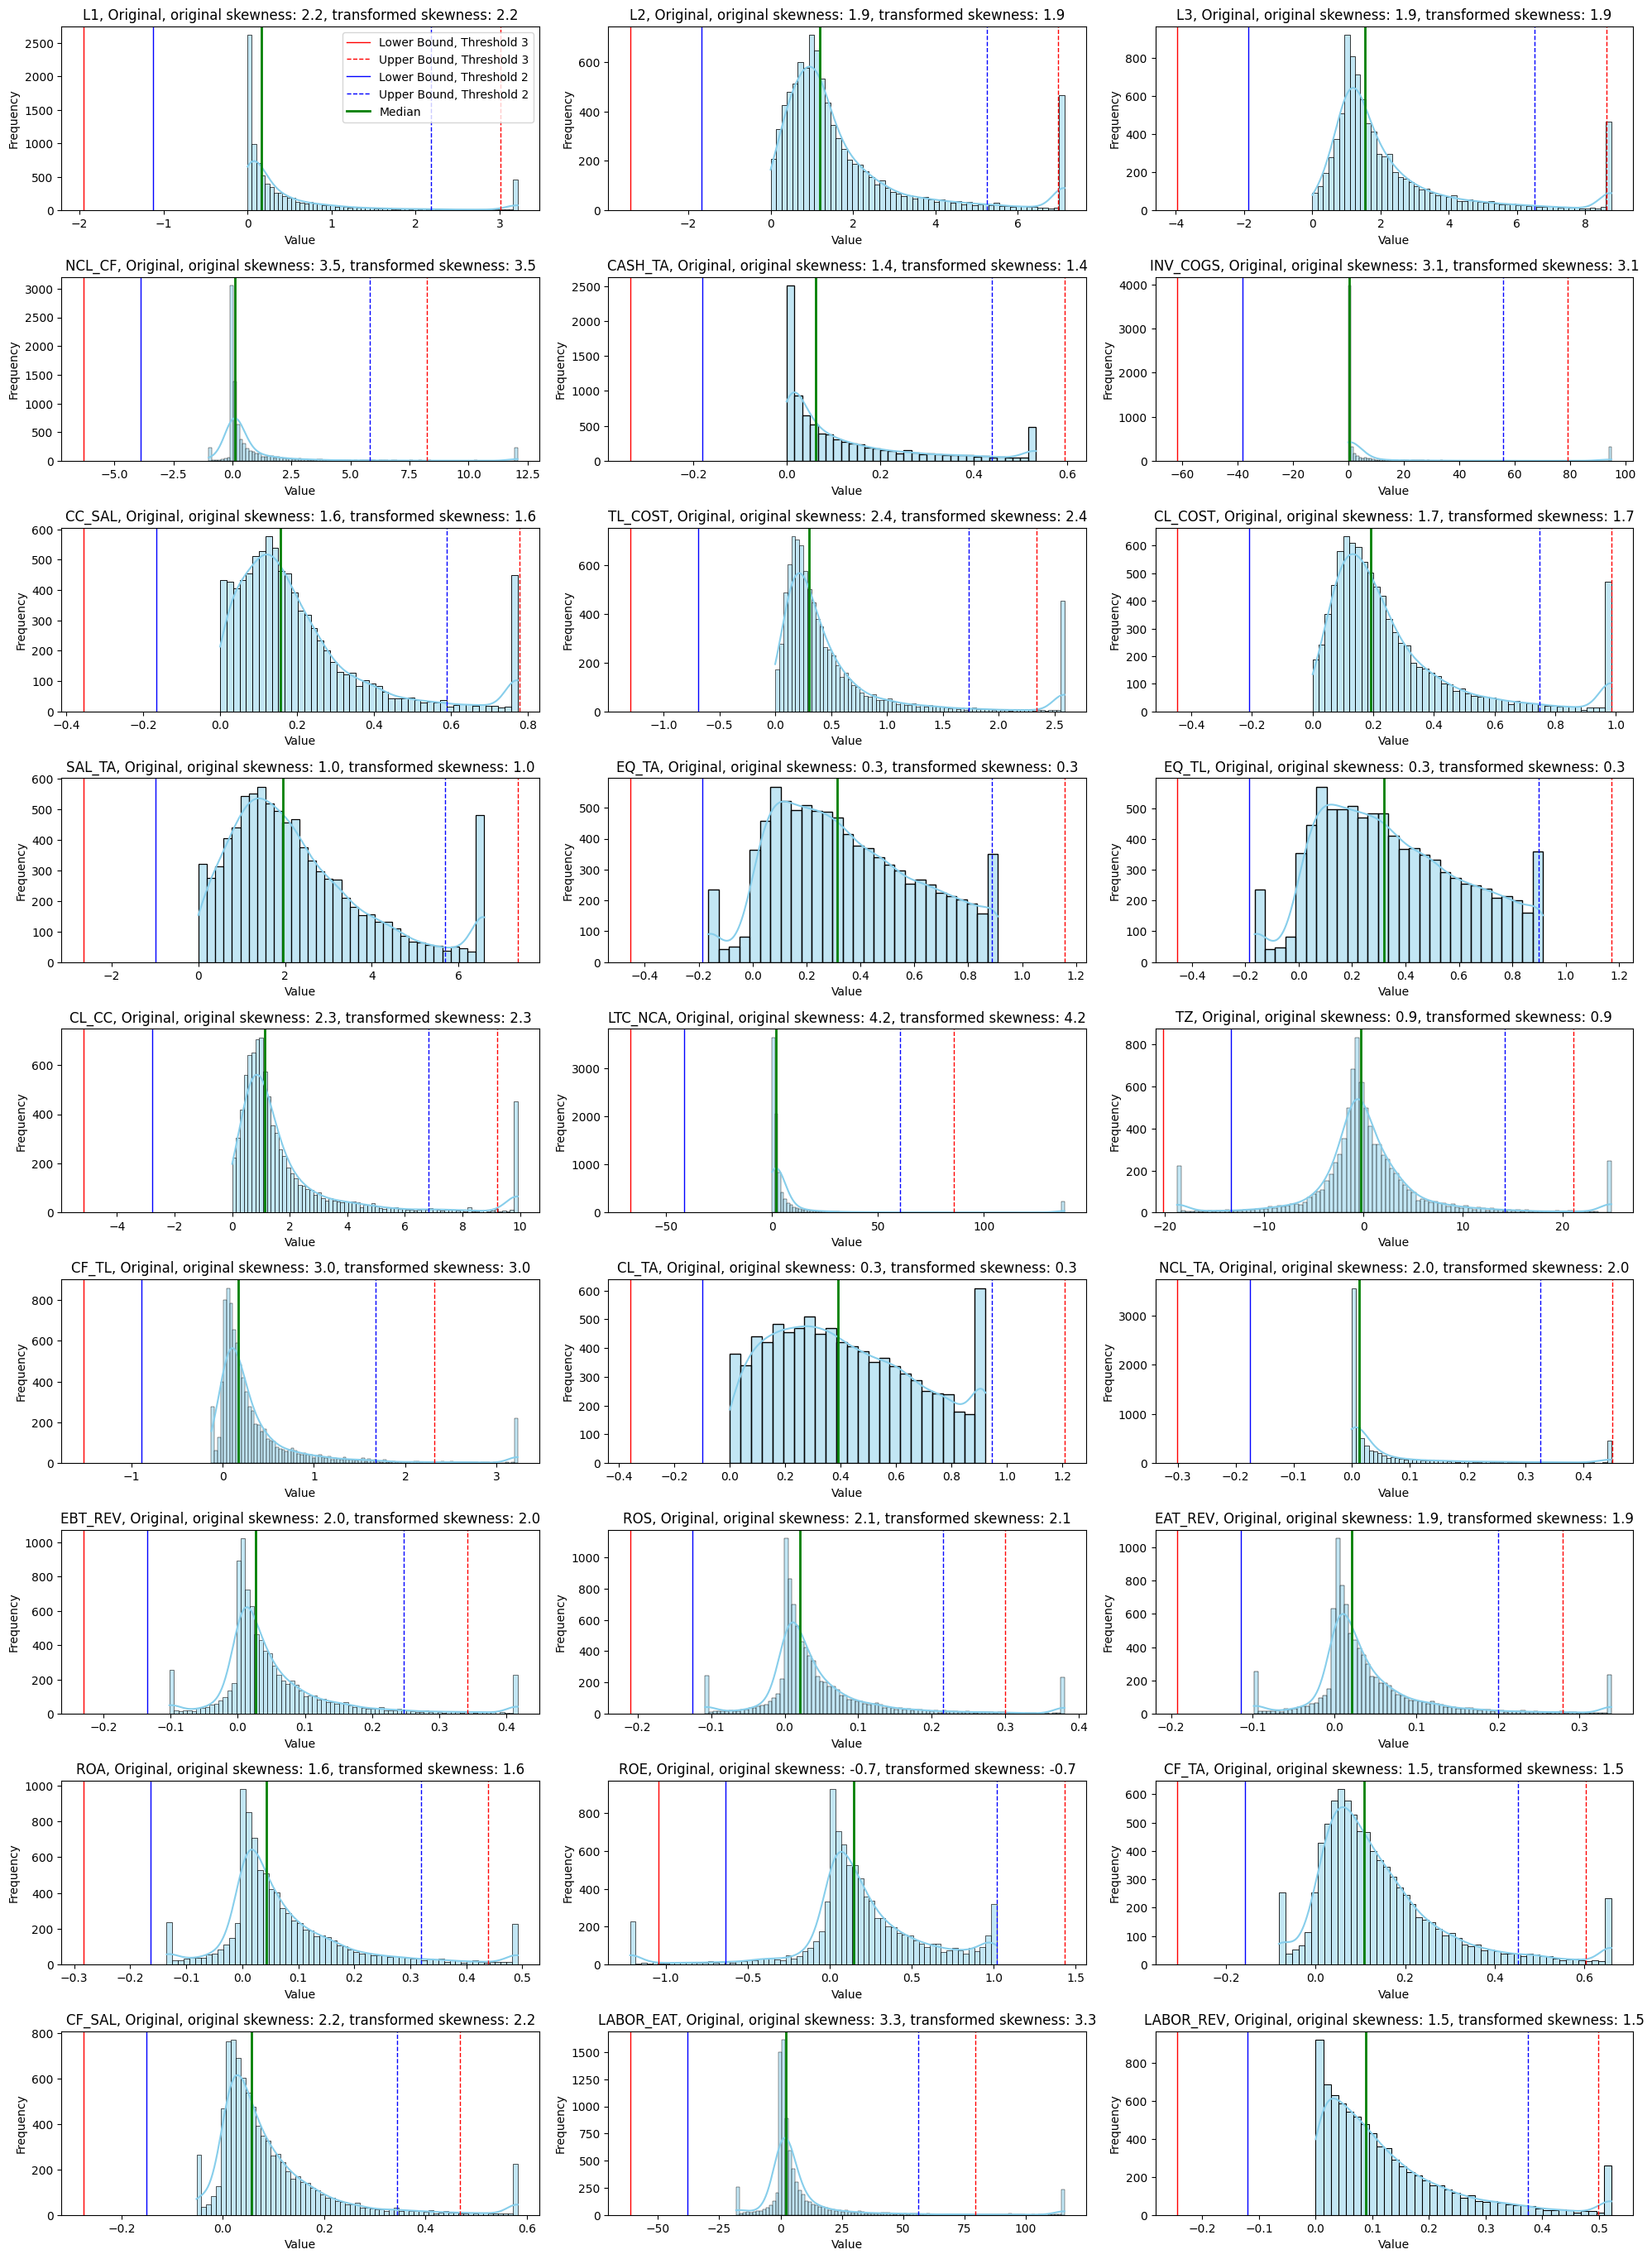

In [15]:
plot_histograms(data_capped, RATIOS, False)

## 2. Analýza multikolinearity

In [16]:
Q = data_filled.query('combined_issue_criteria_3y_off == 1').shape[0]
subset = pd.concat(
    [
        data_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        data_filled.query('combined_issue_criteria_3y_off == 0').sample(Q)
    ], axis = 0
)

In [17]:
# correlated_features = [ 'EAT_REV', 'EQ_TL', 'CF_SAL', 'L2', 'CF_TA']
correlated_features = [ 'EAT_REV', 'EQ_TL', 'CF_TA', 'EBT_REV', 'L2', 'CF_SAL', 'CL_COST']

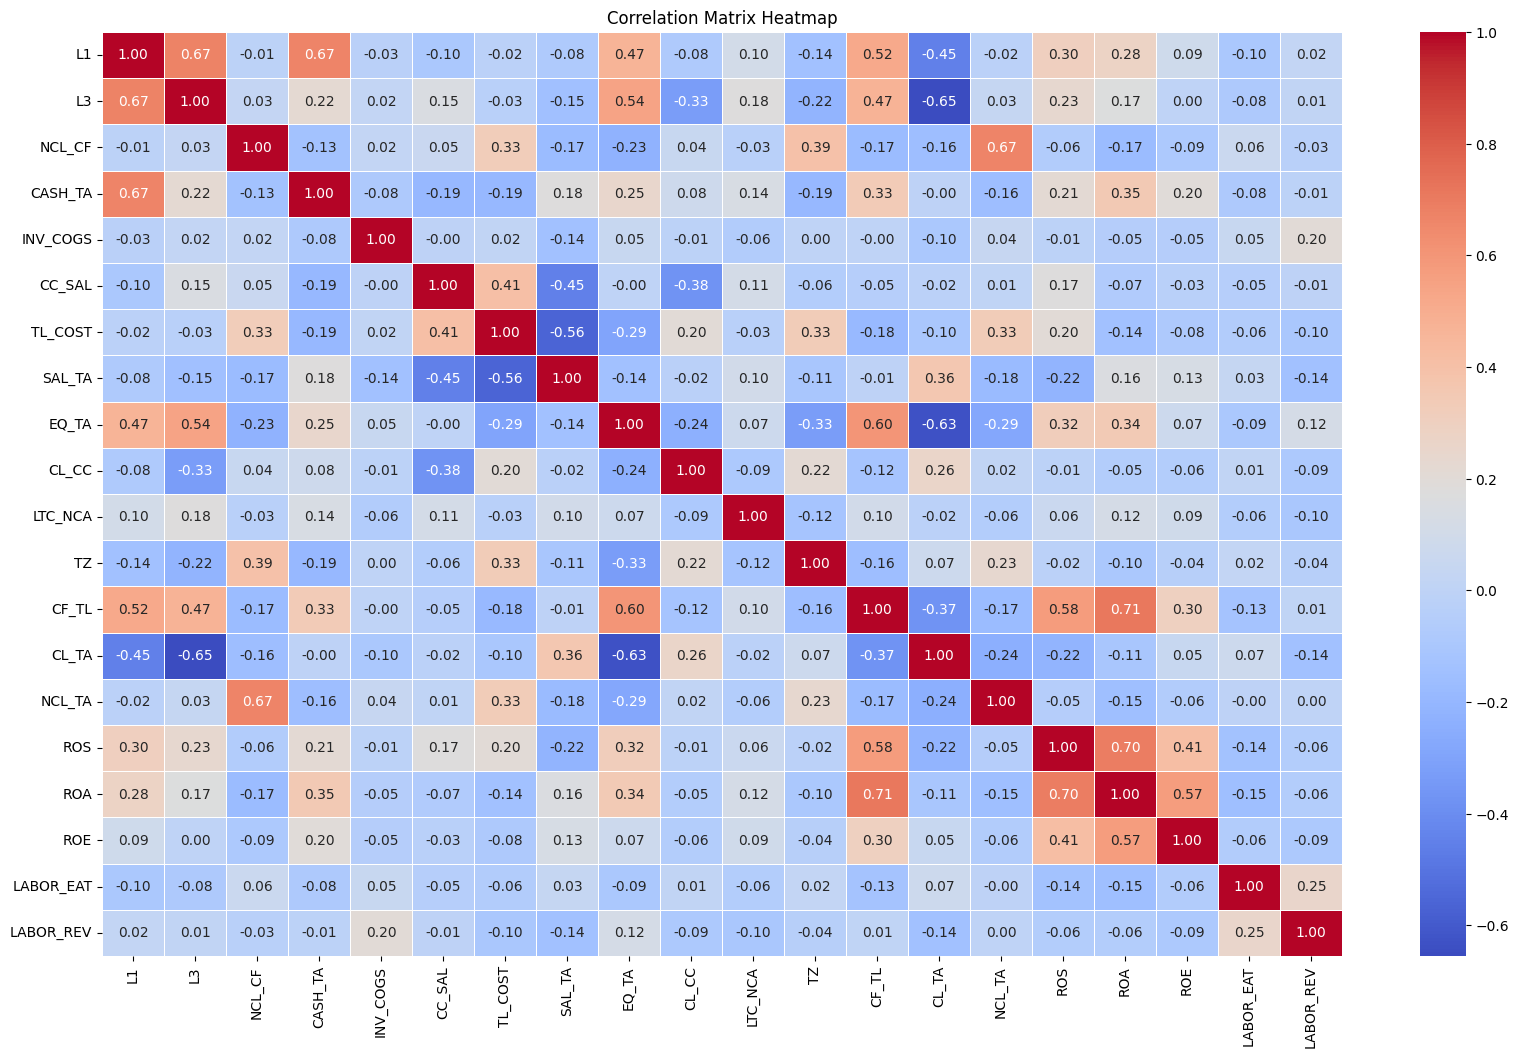

In [18]:

correlation_matrix = data_filled[RATIOS].drop(columns=correlated_features).corr()

# display(correlation_matrix)
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [19]:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = data_filled[RATIOS].copy().drop(columns=correlated_features)
print(df.columns)

df_const = add_constant(df)

vif_data = pd.DataFrame()
vif_data['feature'] = df_const.columns
vif_data['VIF'] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]


print(vif_data.sort_values('VIF').to_latex(index = False))

Index(['L1', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'SAL_TA', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'NCL_TA',
       'ROS', 'ROA', 'ROE', 'LABOR_EAT', 'LABOR_REV'],
      dtype='object')
\begin{tabular}{lr}
\toprule
  feature &       VIF \\
\midrule
 INV\_COGS &  1.069892 \\
  LTC\_NCA &  1.112369 \\
LABOR\_EAT &  1.123822 \\
LABOR\_REV &  1.224552 \\
       TZ &  1.475640 \\
      ROE &  1.569276 \\
    CL\_CC &  1.784828 \\
   NCL\_CF &  2.113359 \\
   SAL\_TA &  2.403589 \\
   NCL\_TA &  2.426357 \\
   CC\_SAL &  2.514982 \\
      ROS &  2.791687 \\
  TL\_COST &  2.899334 \\
  CASH\_TA &  2.925567 \\
    CF\_TL &  3.525961 \\
       L3 &  3.602484 \\
    EQ\_TA &  4.031354 \\
      ROA &  4.341163 \\
    CL\_TA &  4.405254 \\
       L1 &  4.880723 \\
    const & 52.344060 \\
\bottomrule
\end{tabular}



In [20]:
from scipy.stats import shapiro

def check_normality(dataframe):
    results = {}

    for column in dataframe.columns:
        if dataframe[column].dtype.kind not in 'biufc':
            continue
        
        stat, p_value = shapiro(dataframe[column].dropna())
        
        results[column] = {'Statistic': stat, 'P-value': p_value}

    return results


pd.DataFrame(check_normality(data_filled[RATIOS])).T

c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistic       P-value
L1          0.642726  0.000000e+00
L2          0.754087  0.000000e+00
L3          0.747465  0.000000e+00
NCL_CF      0.470894  0.000000e+00
CASH_TA     0.784608  0.000000e+00
INV_COGS    0.429720  0.000000e+00
CC_SAL      0.816807  0.000000e+00
TL_COST     0.662627  0.000000e+00
CL_COST     0.790898  0.000000e+00
SAL_TA      0.907308  0.000000e+00
EQ_TA       0.968320  1.930429e-40
EQ_TL       0.968988  4.111340e-40
CL_CC       0.665326  0.000000e+00
LTC_NCA     0.357087  0.000000e+00
TZ          0.829700  0.000000e+00
CF_TL       0.615499  0.000000e+00
CL_TA       0.956662  1.401298e-45
NCL_TA      0.612891  0.000000e+00
EBT_REV     0.782297  0.000000e+00
ROS         0.769402  0.000000e+00
EAT_REV     0.792010  0.000000e+00
ROA         0.845907  0.000000e+00
ROE         0.891493  0.000000e+00
CF_TA       0.864856  0.000000e+00
CF_SAL      0.757100  0.000000e+00
LABOR_EAT   0.535934  0.000000e+00
LABOR_REV   0.824825  0.000000e+00

# 3. Overenie diskriminacnej schopnosti

In [21]:
import pandas as pd
from scipy.stats import ttest_ind, levene

df = pd.DataFrame(subset[RATIOS + ['combined_issue_criteria_3y_off']].drop(columns=correlated_features))

class0 = df[df['combined_issue_criteria_3y_off'] == 0]
class1 = df[df['combined_issue_criteria_3y_off'] == 1]

results = []
for feature in df.columns[:-1]: 
    stat, p_val_levene = levene(class0[feature], class1[feature])
    
    equal_var = p_val_levene > 0.05
    t_stat, p_val_ttest = ttest_ind(class0[feature], class1[feature], equal_var=equal_var)

    equal_mean = p_val_ttest > 0.05
    
    results.append({
        'Feature': feature,
        'Mean 1': class0[feature].mean(),
        'Mean 2': class1[feature].mean(),
        'Levene Statistic': stat,
        'Levene P-value': p_val_levene,
        'T-statistic': t_stat,
        'T-test P-value': p_val_ttest,
        'Equal Variances Assumed': equal_var,
        'Equal Mean': equal_mean
    })

results_df = pd.DataFrame(results).sort_values('T-test P-value')
display(results_df)


Feature    Mean 1     Mean 2  Levene Statistic  Levene P-value  \
8       EQ_TA  0.387279   0.131018         41.283217    1.695031e-10   
13      CL_TA  0.401774   0.606327         16.571138    4.895673e-05   
17        ROE  0.242862   0.011289        202.562926    1.443261e-43   
12      CF_TL  0.445892   0.209117         27.462734    1.796374e-07   
15        ROS  0.050010   0.017552          0.726317    3.941967e-01   
1          L3  2.351665   1.628897         24.784498    7.044979e-07   
0          L1  0.537153   0.300682         40.253472    2.836543e-10   
7      SAL_TA  2.235744   2.803365         50.398592    1.819917e-12   
16        ROA  0.087439   0.045802          2.134542    1.441938e-01   
9       CL_CC  1.988577   2.681995         18.312005    1.977125e-05   
11         TZ  0.260873   2.116976         40.298308    2.773626e-10   
6     TL_COST  0.503430   0.622334         12.633085    3.890866e-04   
4    INV_COGS  8.557785   5.579113         12.254710    4.757728e-04   
14     NCL_TA  0.064680   0.080451          7.683896    5.630850e-03   
3     CASH_TA  0.130108   0.114888          2.769381    9.626319e-02   
5      CC_SAL  0.208422   0.224450         10.551578    1.182985e-03   
18  LABOR_EAT  7.676483   9.307255         10.248648    1.392511e-03   
19  LABOR_REV  0.121749   0.113004          2.172714    1.406588e-01   
2      NCL_CF  0.850658   1.017910          6.168535    1.309765e-02   
10    LTC_NCA  8.997356  10.395948          2.243702    1.343406e-01   

    T-statistic  T-test P-value  Equal Variances Assumed  Equal Mean  
8     21.285874    1.739621e-89                    False       False  
13   -16.170136    7.213592e-55                    False       False  
17     9.186012    1.512313e-19                    False       False  
12     8.168012    6.095506e-16                    False       False  
15     7.823876    8.812655e-15                     True       False  
1      7.736915    1.720917e-14                    False       False  
0      6.826129    1.231275e-11                    False       False  
7     -6.676938    3.321119e-11                    False       False  
16     6.614169    4.955801e-11                     True       False  
9     -5.543789    3.430900e-08                    False       False  
11    -5.129381    3.265401e-07                    False       False  
6     -4.011042    6.303954e-05                    False       False  
4      3.543592    4.063021e-04                    False       False  
14    -2.581937    9.908553e-03                    False       False  
3      2.080628    3.761376e-02                     True       False  
5     -1.686131    9.195175e-02                    False        True  
18    -1.436942    1.509270e-01                    False        True  
19     1.408248    1.592362e-01                     True        True  
2     -1.387564    1.654565e-01                    False        True  
10    -1.087536    2.769506e-01                     True        True

In [23]:
import pandas as pd
from scipy.stats import mannwhitneyu
from sklearn.utils import resample


results_complete_df = pd.DataFrame()

df = pd.DataFrame(subset[RATIOS + ['combined_issue_criteria_3y_off']].drop(columns=correlated_features))



class0 = df[df['combined_issue_criteria_3y_off'] == 0]
class1 = df[df['combined_issue_criteria_3y_off'] == 1]

n_class0 = len(class0)
n_class1 = len(class1)

if n_class0 > n_class1:
    class0 = resample(class0, replace=False, n_samples=n_class1, random_state=42)
else:
    class1 = resample(class1, replace=False, n_samples=n_class0, random_state=42)

results = []
for feature in df.columns[:-1]:
    stat, p_val = mannwhitneyu(class0[feature], class1[feature], alternative='two-sided')
      
    results.append({
        'Feature': feature,
        'Median 1': round(class0[feature].median(), 2),
        'Median 2': round(class1[feature].median(), 2),
        # 'Mann-Whitney U Statistic': stat,
        'Mann-Whitney U P-value': round(p_val, 2),
        # 'Significant Difference': p_val < 0.05
    })

results_df = pd.DataFrame(results).sort_values('Mann-Whitney U P-value')
results_df['sknace'] = 'spolu'

results_complete_df = pd.concat([results_complete_df, results_df], axis=0)



for sknace in SKNACE_GROUPS:
    df = pd.DataFrame(subset.query('sknace_division_normalized == @sknace')[RATIOS + ['combined_issue_criteria_3y_off']].drop(columns=correlated_features))

    class0 = df[df['combined_issue_criteria_3y_off'] == 0]
    class1 = df[df['combined_issue_criteria_3y_off'] == 1]

    results = []
    for feature in df.columns[:-1]:
        stat, p_val = mannwhitneyu(class0[feature], class1[feature], alternative='two-sided')
        
        results.append({
            'Feature': feature,
            'Median 1': round(class0[feature].median(), 2),
            'Median 2': round(class1[feature].median(), 2),
            # 'Mann-Whitney U Statistic': stat,
            'Mann-Whitney U P-value': round(p_val, 2),
            # 'Significant Difference': p_val < 0.05
        })

    results_df = pd.DataFrame(results).sort_values('Mann-Whitney U P-value')
    results_df['sknace'] = sknace

    results_complete_df = pd.concat([results_complete_df, results_df], axis=0)


print(results_complete_df.query('sknace == "spolu"').drop(columns='sknace').to_latex(index = False))

results_wide = pd.pivot_table(results_complete_df, columns= 'sknace', index = 'Feature', values=['Mann-Whitney U P-value'])


# results_wide.columns = results_wide.columns.swaplevel(0,1)
# results_wide = results_wide.sort_index(axis=1)
print(results_wide.reset_index().to_latex(index=False))
display(results_wide.reset_index())

\begin{tabular}{lrrr}
\toprule
  Feature &  Median 1 &  Median 2 &  Mann-Whitney U P-value \\
\midrule
       L1 &      0.19 &      0.08 &                    0.00 \\
      ROE &      0.17 &      0.05 &                    0.00 \\
      ROA &      0.05 &      0.01 &                    0.00 \\
      ROS &      0.03 &      0.00 &                    0.00 \\
    CL\_TA &      0.36 &      0.64 &                    0.00 \\
    CF\_TL &      0.21 &      0.07 &                    0.00 \\
       TZ &     -0.36 &      0.69 &                    0.00 \\
  LTC\_NCA &      1.76 &      1.24 &                    0.00 \\
LABOR\_EAT &      1.73 &      0.56 &                    0.00 \\
    CL\_CC &      1.11 &      1.46 &                    0.00 \\
   SAL\_TA &      1.93 &      2.25 &                    0.00 \\
  TL\_COST &      0.30 &      0.40 &                    0.00 \\
 INV\_COGS &      0.37 &      0.24 &                    0.00 \\
   NCL\_CF &      0.07 &      0.02 &                    0.00 \\
      

Feature Mann-Whitney U P-value                                    
sknace                                 C     F     G     H     M other spolu
0         CASH_TA                   0.00  0.00  0.59  0.75  0.22  0.35  0.01
1          CC_SAL                   0.83  0.22  0.67  0.85  0.69  0.79  0.69
2           CF_TL                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
3           CL_CC                   0.00  0.08  0.00  0.03  0.04  0.01  0.00
4           CL_TA                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
5           EQ_TA                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
6        INV_COGS                   0.16  0.60  0.01  0.09  0.06  0.00  0.00
7              L1                   0.00  0.00  0.01  0.08  0.00  0.00  0.00
8              L3                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
9       LABOR_EAT                   0.00  0.71  0.00  0.89  0.38  0.00  0.00
10      LABOR_REV                   0.93  0.88  0.00  0.02  0.00  0.02  0.00
11        LTC_NCA                   0.00  0.12  0.00  0.00  0.28  0.00  0.00
12         NCL_CF                   0.01  0.45  0.00  0.41  0.63  0.00  0.00
13         NCL_TA                   0.43  0.34  0.13  0.75  0.81  0.17  0.33
14            ROA                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
15            ROE                   0.00  0.00  0.00  0.00  0.02  0.02  0.00
16            ROS                   0.00  0.00  0.00  0.00  0.00  0.00  0.00
17         SAL_TA                   0.16  0.61  0.00  0.15  0.13  0.00  0.00
18        TL_COST                   0.00  0.00  0.01  0.67  0.41  0.86  0.00
19             TZ                   0.03  0.00  0.00  0.08  0.03  0.01  0.00

In [24]:
equal_pdf = ['NCL_TA', 'CC_SAL']
equal_pdf_in_subgroups = ['SAL_TA', 'CASH_TA','INV_COGS','LABOR_EAT','LABOR_REV','NCL_CF','TL_COST']

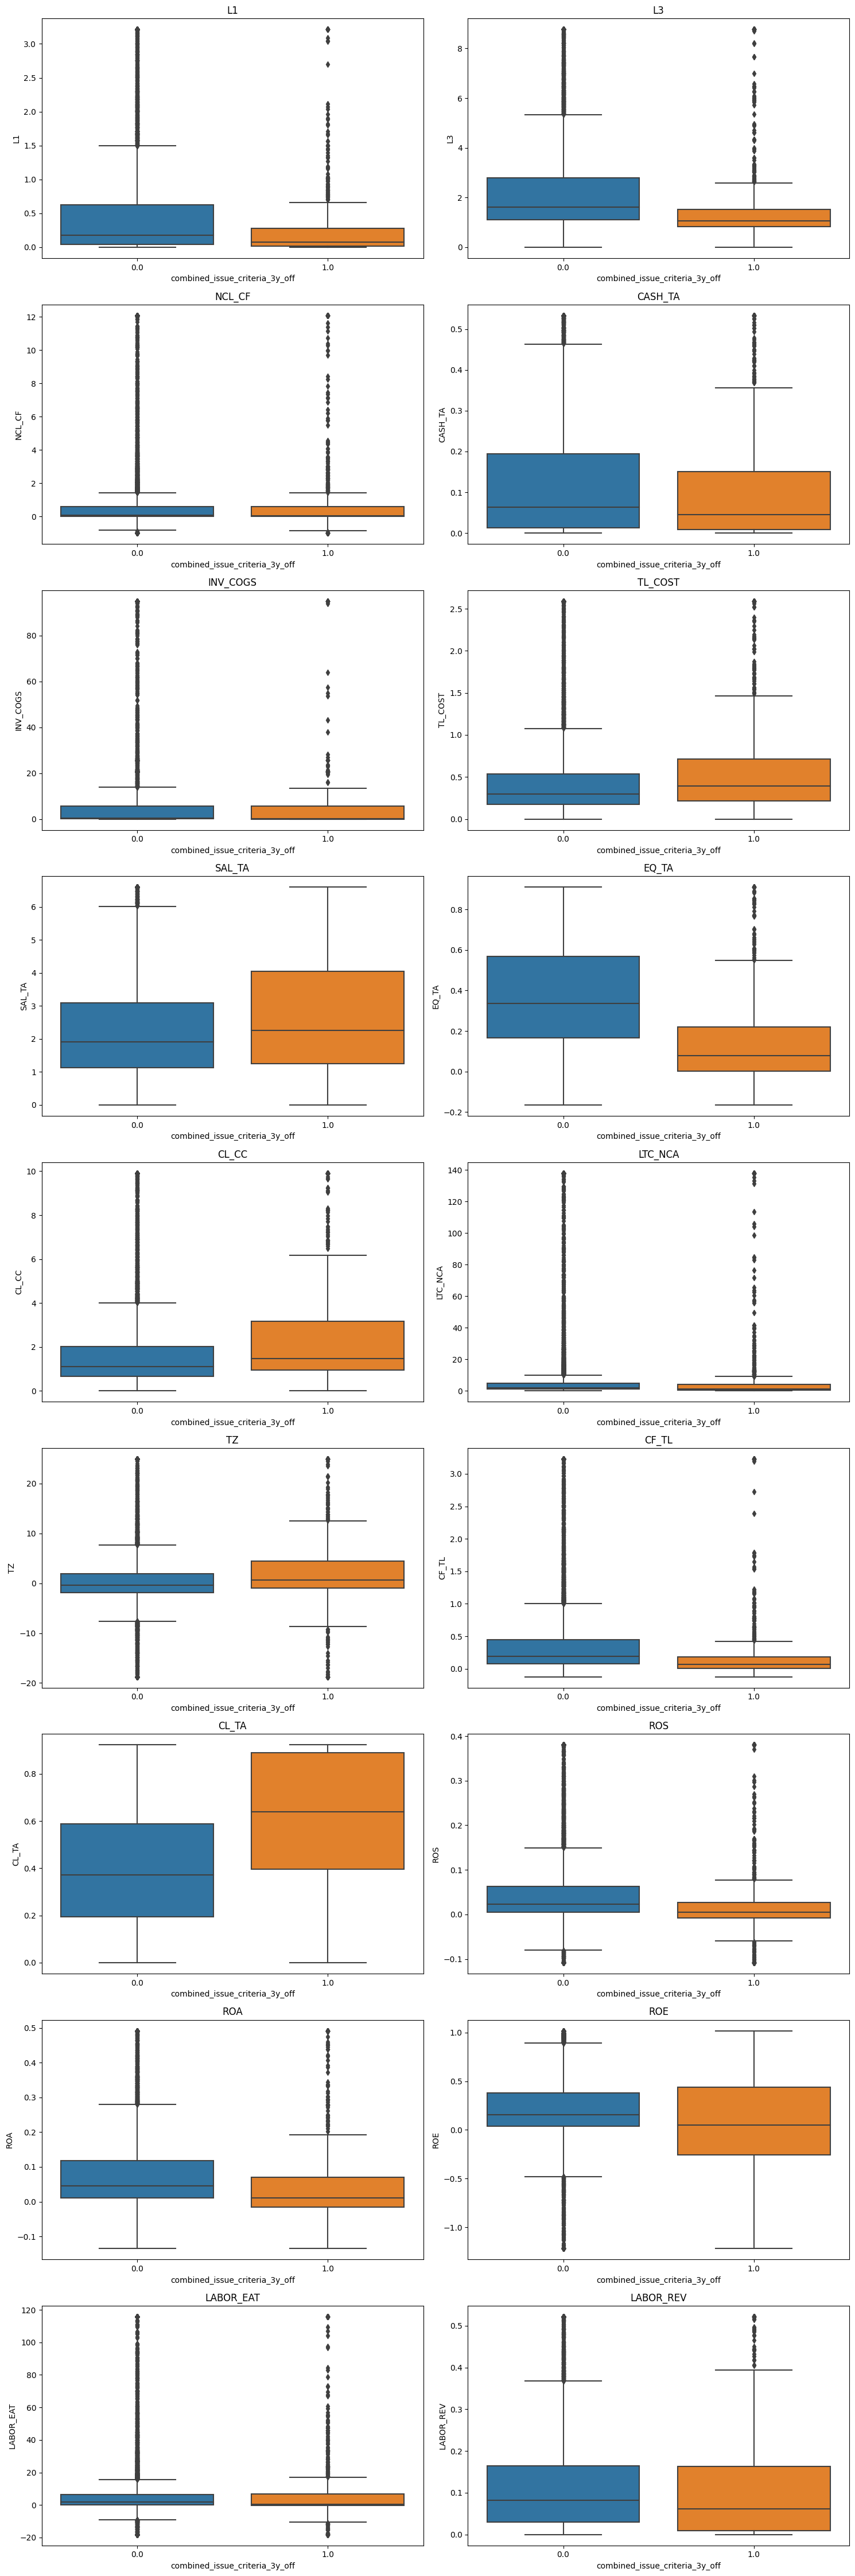

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = data_filled[RATIOS + ['combined_issue_criteria_3y_off']].drop(columns=correlated_features + equal_pdf)

features = df.columns.drop('combined_issue_criteria_3y_off')

num_features = len(features)

n_rows = (num_features + 1) // 2

fig, axes = plt.subplots(n_rows, 2, figsize=(15, n_rows * 5))

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='combined_issue_criteria_3y_off', y=feature, data=df, ax=axes[i])
    axes[i].set_title(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


c:\Users\matus.rohal\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


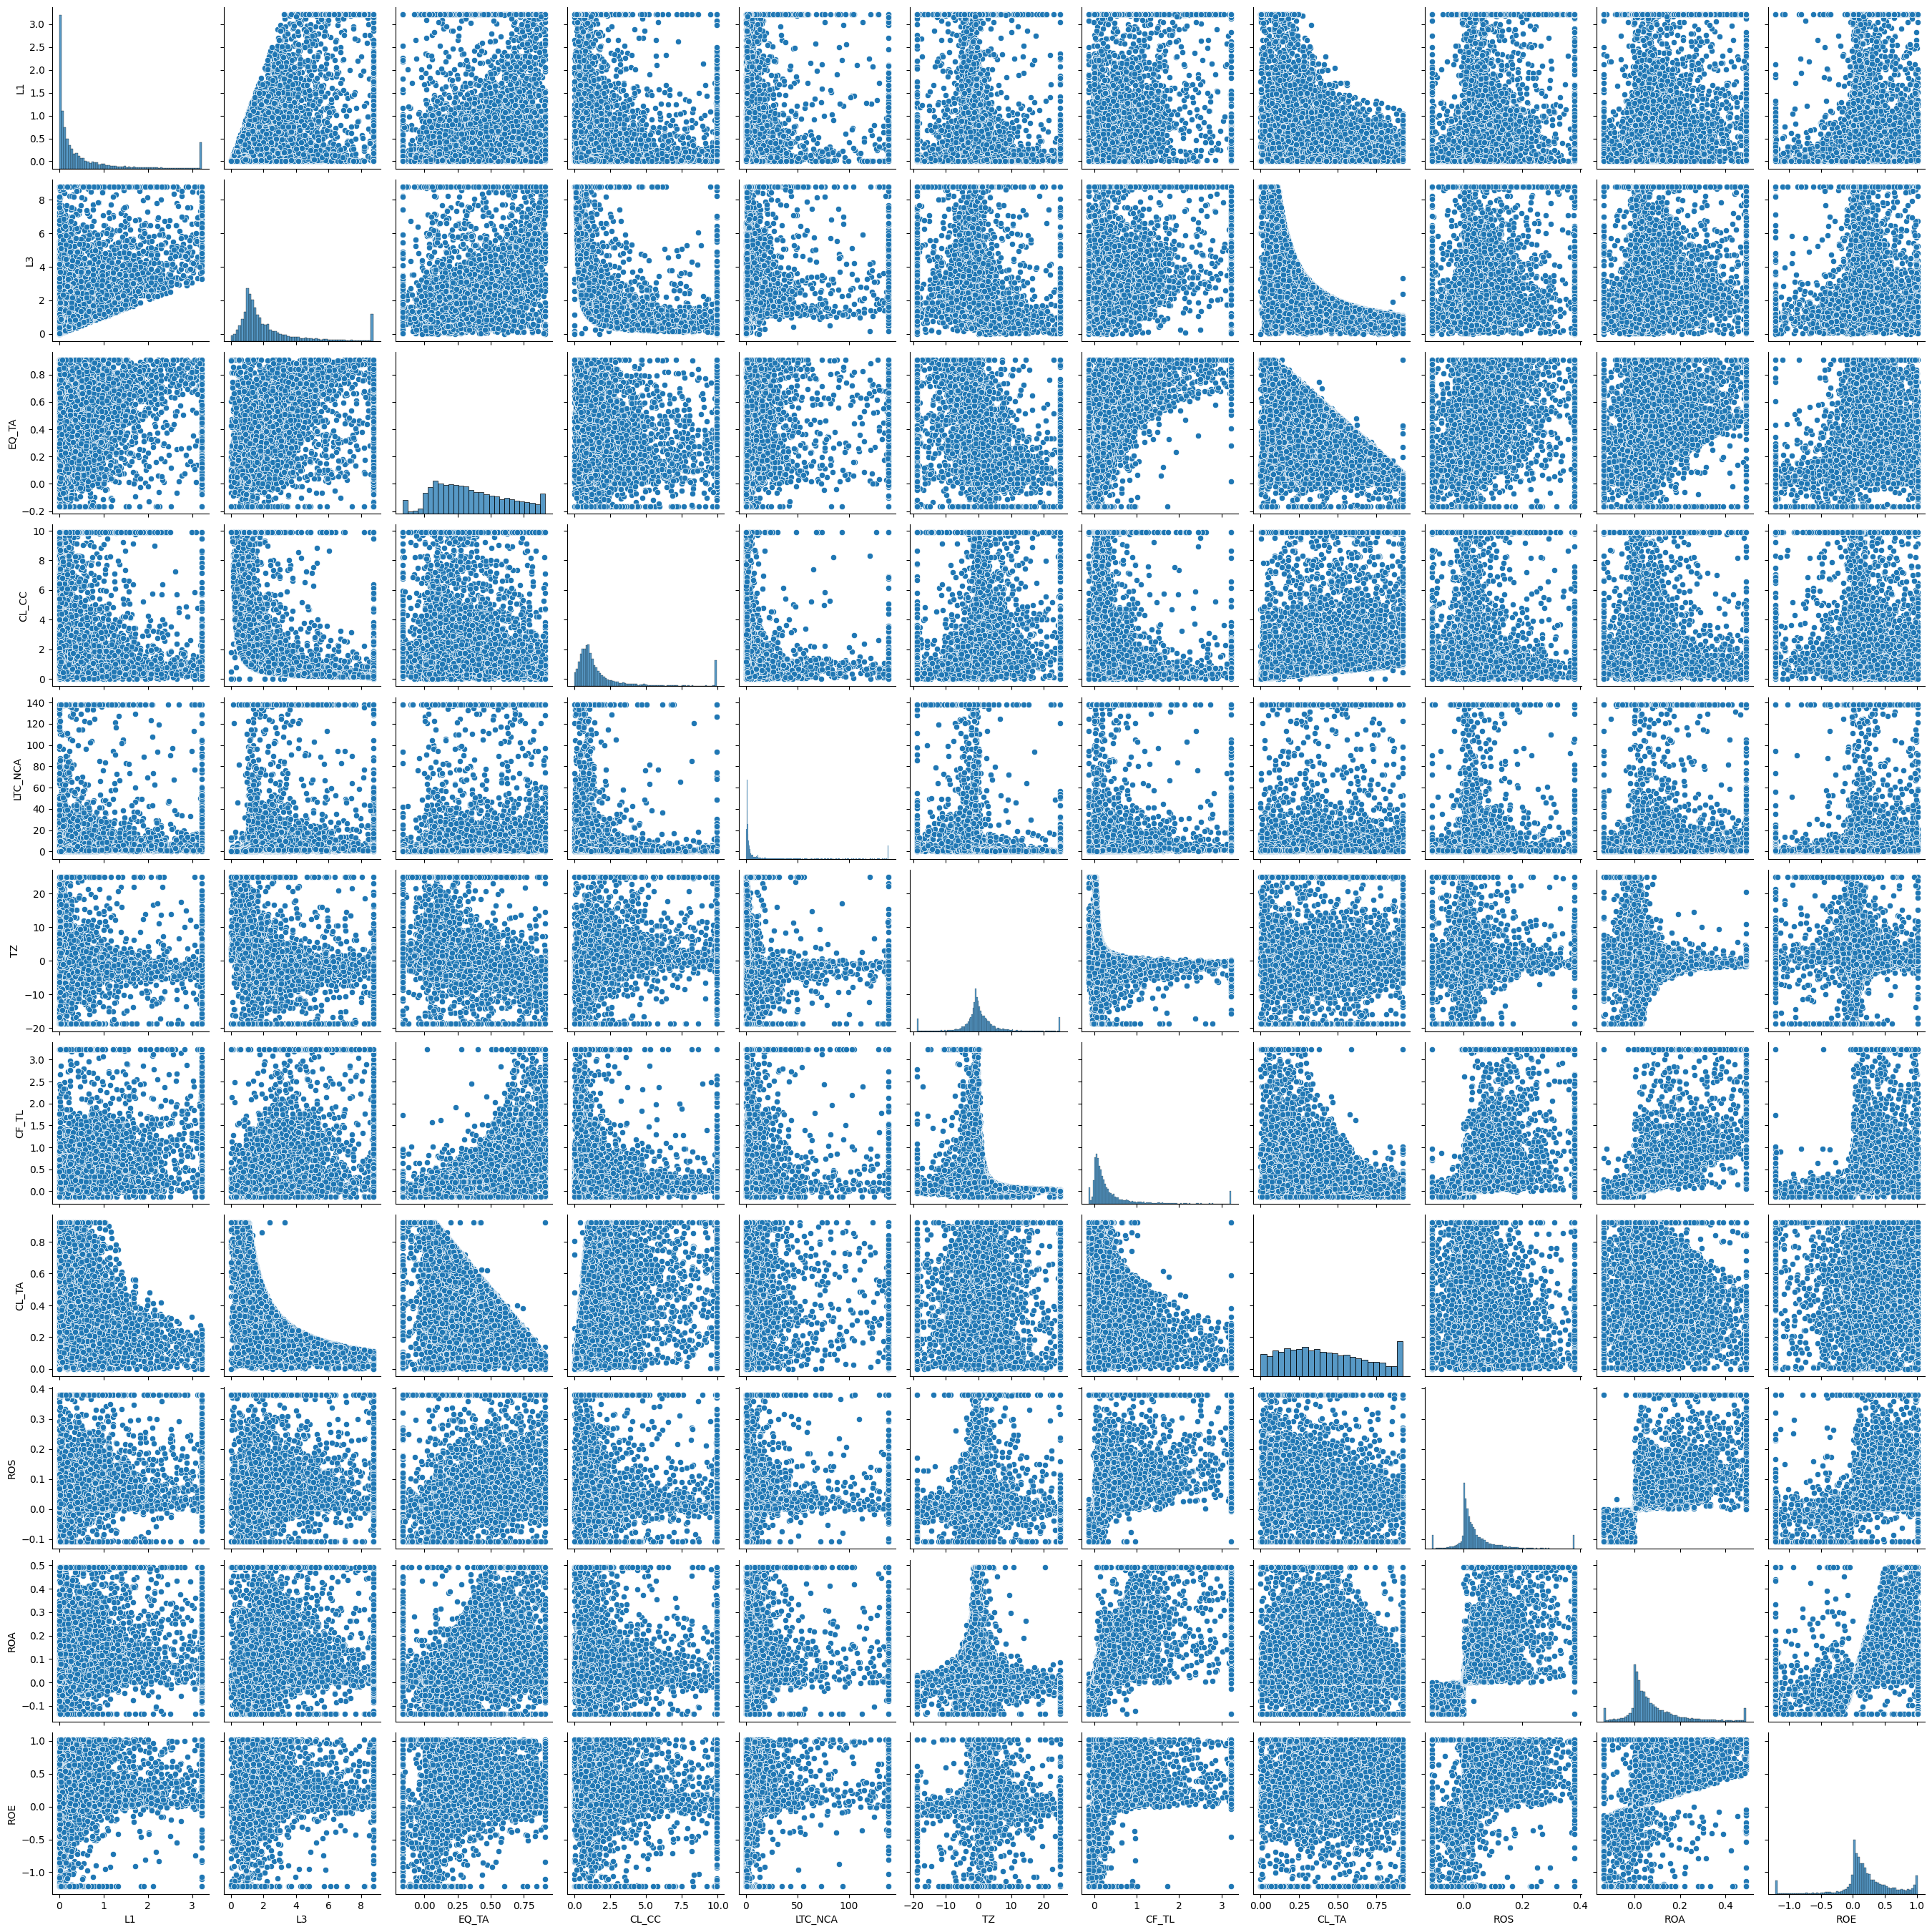

In [26]:
sns.pairplot(data_filled[RATIOS].drop(columns=correlated_features + equal_pdf + equal_pdf_in_subgroups))
plt.show()